## Characterwise Double-Stacked LSTM as Author


In [9]:
import numpy
import theano
from theano import tensor

from blocks.bricks import Tanh
from blocks.bricks.recurrent import GatedRecurrent
from blocks.bricks.sequence_generators import (SequenceGenerator, Readout, SoftmaxEmitter, LookupFeedback)
from blocks.graph import ComputationGraph

from blocks.algorithms import GradientDescent, Scale, RMSProp
from blocks.initialization import Orthogonal, IsotropicGaussian, Constant
from blocks.model import Model

from blocks.monitoring import aggregation
from blocks.extensions import FinishAfter, Printing
from blocks.extensions.saveload import Checkpoint
from blocks.extensions.monitoring import TrainingDataMonitoring

from blocks.main_loop import MainLoop
import blocks.serialization

from blocks.select import Selector

import logging
import pprint
logger = logging.getLogger(__name__)

print theano.config

floatX (('float64', 'float32', 'float16')) 
    Doc:  Default floating-point precision for python casts.

Note: float16 support is experimental, use at your own risk.
    Value:  float64

warn_float64 (('ignore', 'warn', 'raise', 'pdb')) 
    Doc:  Do an action when a tensor variable with float64 dtype is created. They can't be run on the GPU with the current(old) gpu back-end and are slow with gamer GPUs.
    Value:  ignore

cast_policy (('custom', 'numpy+floatX')) 
    Doc:  Rules for implicit type casting
    Value:  custom

int_division (('int', 'raise', 'floatX')) 
    Doc:  What to do when one computes x / y, where both x and y are of integer types
    Value:  int

device (cpu, gpu*, opencl*, cuda*) 
    Doc:  Default device for computations. If gpu*, change the default to try to move computation to it and to put shared variable of float32 on it. Do not use upper case letters, only lower case even if NVIDIA use capital letters.
    Value:  cpu

gpuarray.init_device (<type 'str'>)

In [2]:
# Dictionaries
import string

all_chars = [ a for a in string.printable]+['<UNK>']
code2char = dict(enumerate(all_chars))
char2code = {v: k for k, v in code2char.items()}

In [3]:
data_file = 'Shakespeare.poetry.txt'
seq_len = 100    # The input file is learned in chunks of text this large

# Network parameters
num_states=len(char2code)  # This is the size of the one-hot input and SoftMax output layers
dim = 32 # 128 # 10
hidden_state_dim = 32 # 128 # 8
feedback_dim = num_states

batch_size = 50  # This is for mini-batches : Helps optimize GPU workload
num_epochs = 10  # Number of reads-through of corpus to do a training

data_path = '../data/'  + data_file
save_path = '../models/' + data_file + '.model'

In [4]:
#from fuel.datasets import Dataset
from fuel.streams import DataStream
from fuel.schemes import ConstantScheme

from fuel.datasets import Dataset

#from fuel.datasets import TextFile
#dataset = TextFile([data_file], bos_token=None, eos_token=None, level="character", dictionary=char2code)
#data_stream = DataStream(dataset, iteration_scheme=ConstantScheme(batch_size))

class CharacterTextFile(Dataset):
    provides_sources = ("data",)

    def __init__(self, fname, chunk_len, dictionary, **kwargs):
        self.fname = fname
        self.chunk_len = chunk_len
        self.dictionary = dictionary 
        super(CharacterTextFile, self).__init__(**kwargs)

    def open(self):
        return open(self.fname,'r')

    def get_data(self, state, request):
        assert isinstance(request, int)
        x = numpy.zeros((self.chunk_len, request), dtype='int64')
        for i in range(request):
            txt=state.read(self.chunk_len)
            if len(txt)<self.chunk_len: raise StopIteration
            #print(">%s<\n" % (txt,))
            x[:, i] = [ self.dictionary[c] for c in txt ]
        return (x,)    
    
    def close(self, state):
        state.close()
        
dataset = CharacterTextFile(data_path, chunk_len=seq_len, dictionary=char2code)
data_stream = DataStream(dataset, iteration_scheme=ConstantScheme(batch_size))
a=data_stream.get_data(10)
#[ code2char[v] for v in [94, 27, 21, 94, 16, 14, 54, 23, 14, 12] ]      # Horizontally
#[ code2char[v] for v in [94, 94,95,36,94,47,50,57,40,53,68,54,94,38] ]  # Vertically
''.join([ code2char[v] for v in a[0][:,0] ])

"  \tA LOVER'S COMPLAINT\n\n\n\nFROM off a hill whose concave womb reworded\nA plaintful story from a siste"

## Defining the Model
Actually, it's a single layer of GRU for now...  (rather than a double-stacked LSTM)

In [5]:
transition = GatedRecurrent(name="transition", dim=hidden_state_dim, activation=Tanh())
generator =  SequenceGenerator(
                Readout(readout_dim=num_states, source_names=["states"],
                        emitter=SoftmaxEmitter(name="emitter"),
                        feedback_brick=LookupFeedback(
                            num_states, feedback_dim, name='feedback'),
                        name="readout"),
                transition,
                weights_init=IsotropicGaussian(0.01), biases_init=Constant(0),
                name="generator"
)

generator.push_initialization_config()
transition.weights_init = Orthogonal()
generator.initialize()

In [6]:
# Give an idea of what's going on.
logger.info("Parameters:\n" + pprint.pformat(
    [(key, value.get_value().shape) for key, value in Selector(generator).get_params().items()],
    width=120))
#logger.info("Markov chain entropy: {}".format(MarkovChainDataset.entropy))
#logger.info("Expected min error: {}".format( -MarkovChainDataset.entropy * seq_len))

In [7]:
# Build the cost computation graph.
x = tensor.lmatrix('data')
cost = aggregation.mean(generator.cost_matrix(x[:, :]).sum(), x.shape[1])
cost.name = "sequence_log_likelihood"

model=Model(cost)

algorithm = GradientDescent(
    cost=cost, params=list(Selector(generator).get_params().values()),
    step_rule=RMSProp())  # was Scale(0.001)

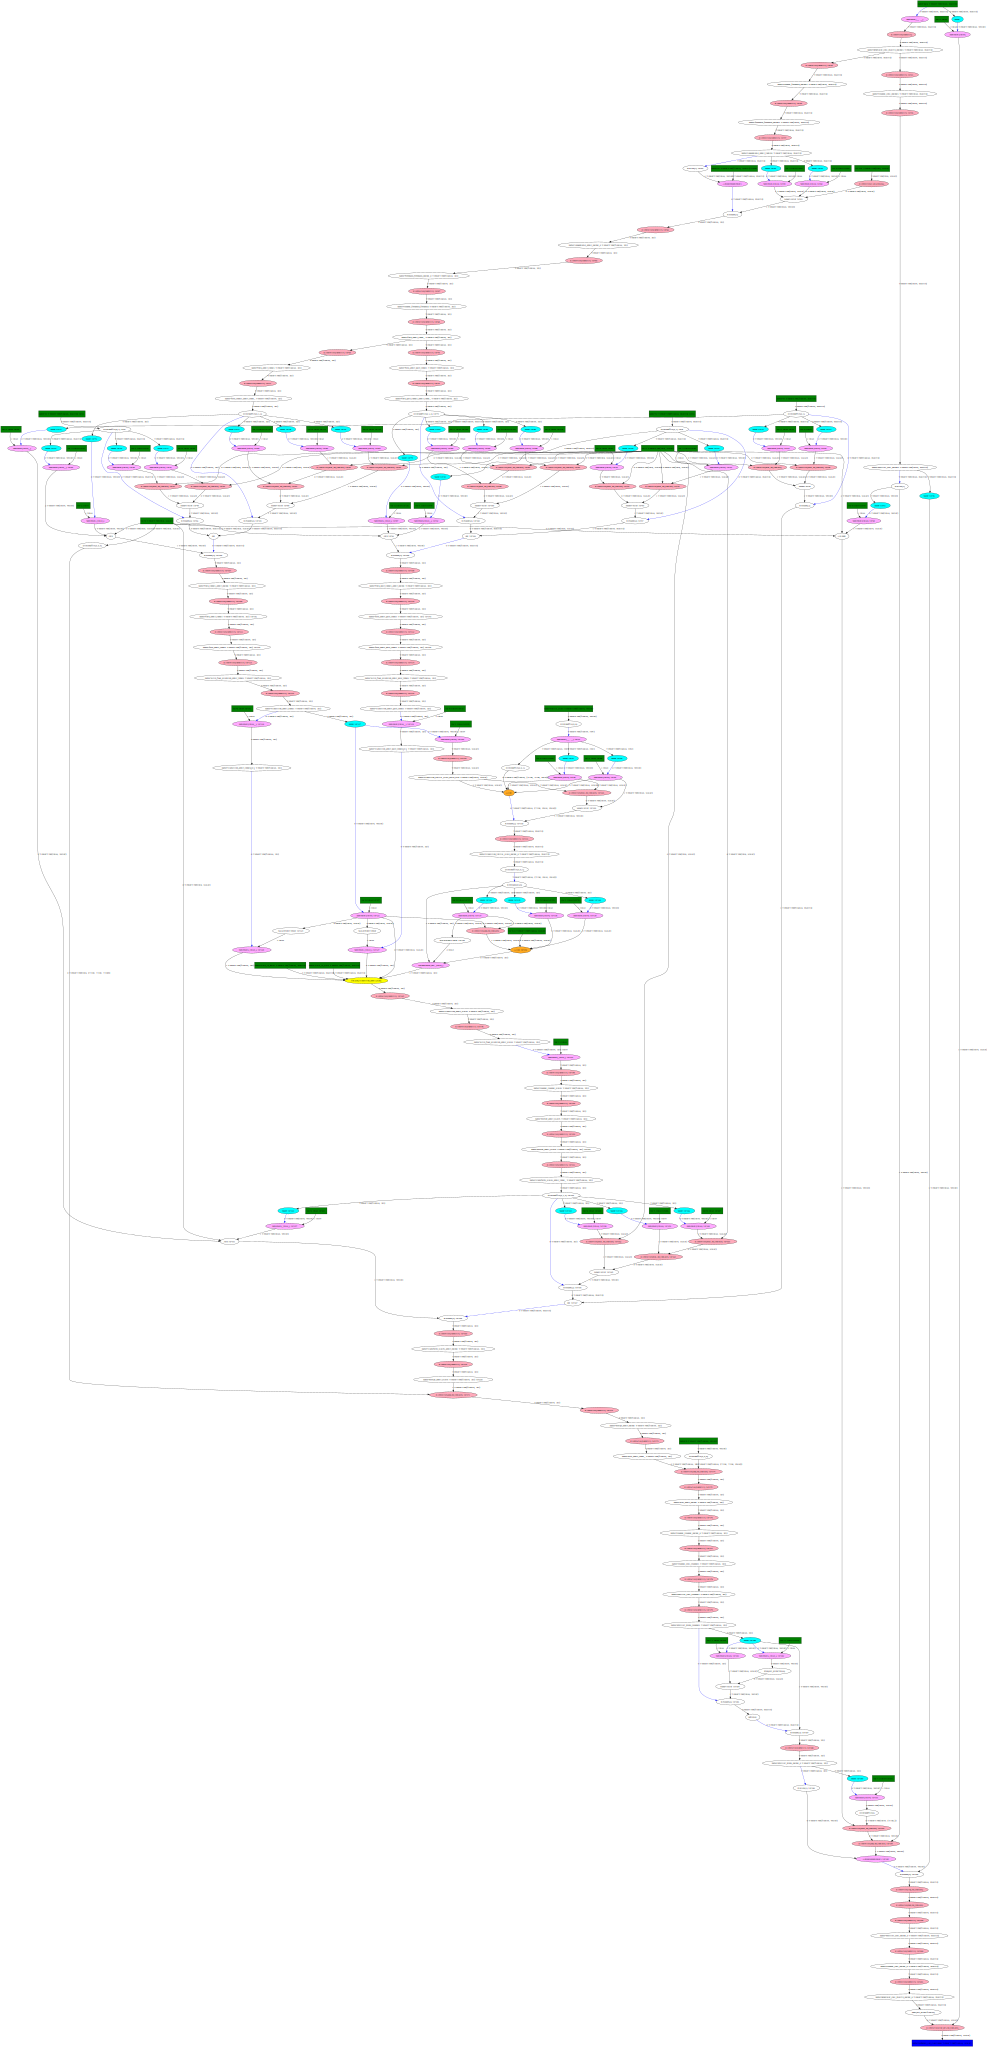

In [8]:
from IPython.display import SVG
SVG(theano.printing.pydotprint(cost, return_image=True, format='svg'))

In [10]:
main_loop = MainLoop(
    algorithm=algorithm,
    data_stream=data_stream,
    model=model,
    extensions=[
        FinishAfter(after_n_epochs=num_epochs),
        TrainingDataMonitoring([cost], prefix="this_step", after_batch=True),
        TrainingDataMonitoring([cost], prefix="average",   every_n_batches=100),
        Checkpoint(save_path, every_n_batches=500),
        Printing(every_n_batches=100)
    ]
)

In [11]:
main_loop.run()

/home/andrewsm/SEER/services/deepner/server/env/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:134: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *

Blocks will complete this epoch iteration of training and run extensions before exiting. If you do not want to complete this epoch, press CTRL + C again to stop training after the current batch.

Blocks will complete the current batch and run extensions before exiting. If you do not want to complete this batch, press CTRL + C again. WARNING: Note that this will end training immediately, and extensions that e.g. save your training progress won't be run.



-------------------------------------------------------------------------------
BEFORE FIRST EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 0
	 received_first_batch: False
	 training_started: True
Log records from the iteration 0:



KeyboardInterrupt: 

In [ ]:

## continuing models : (new method is not cPickle) :
# https://groups.google.com/forum/#!topic/blocks-users/jns-KKWTtko
# http://blocks.readthedocs.org/en/latest/serialization.html?highlight=load
## To inspect contents of saved/Checkpoint-ed file :
# unzip -t models/Shakespeare.poetry.txt.model 

#from six.moves import cPickle
#main_loop = cPickle.load(open(save_path, "rb"))
#blocks.serialization.load(save_path)


#def author(input):    
#    pass

#model=Model(cost)

# Read back in from disk
if False:
    model.set_param_values(blocks.serialization.load_parameter_values(save_path))
# Includes generator(?)
#generator = main_loop.model

### This is to sample the learned relationships

In [ ]:
output_length = 1000  # in characters

sampler = ComputationGraph(
    generator.generate(n_steps=output_length, batch_size=1, iterate=True)
)

#print("Sampler variables : ", sampler.variables)

sample = sampler.get_theano_function()

states, outputs, costs = [data[:, 0] for data in sample()]

numpy.set_printoptions(precision=3, suppress=True)
print("Generation cost:\n{}".format(costs.sum()))

#freqs = numpy.bincount(outputs).astype(floatX)
#freqs /= freqs.sum()
#print("Frequencies:\n {} vs {}".format(freqs, MarkovChainDataset.equilibrium))

#trans_freqs = numpy.zeros((num_states, num_states), dtype=floatX)
#for a, b in zip(outputs, outputs[1:]):
#    trans_freqs[a, b] += 1
#trans_freqs /= trans_freqs.sum(axis=1)[:, None]
#print("Transition frequencies:\n{}\nvs\n{}".format(
#    trans_freqs, MarkovChainDataset.trans_prob))

#print(numpy.shape(states))
#print(numpy.shape(outputs))
#print(outputs[:])
print(''.join([ code2char[c] for c in outputs]))

In [ ]:
#blocks.serialization.continue_training(save_path)